In [10]:
# %%
# 1. SETUP AND IMPORTS
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import DistilBertTokenizer

# Import our updated project modules
from data.processing import load_and_prepare_data, create_book_pairs, get_metadata_features, get_text_features
from model.encoders import MLPEncoder, BERTEncoder # CNN and Hybrid can be added later
from model.siamese import SiameseModel
from train.losses import contrastive_loss
from evaluate.plots import plot_roc_curves

# --- CONFIGURATION ---
BATCH_SIZE = 64
EPOCHS = 5
EMBEDDING_DIM = 128
MAX_TITLE_LENGTH = 25 # Increased slightly for book titles
DATA_PATH = "data/kaggle_data/"
# Use a sample size for faster experiments!
PAIR_SAMPLE_SIZE = 20000


In [11]:
# %% [markdown]
# ## 2. Data Loading and Pair Creation

# %%
# Load and process the new dataset
reviews_df, books_df = load_and_prepare_data(data_path=DATA_PATH)

# Create book pairs using the reviews data
pairs_df = create_book_pairs(reviews_df, min_ratings=5, sample_size=PAIR_SAMPLE_SIZE)

# Filter out pairs where one of the books might not have metadata
valid_book_ids = set(books_df['book_id'])
pairs_df = pairs_df[pairs_df['book_a'].isin(valid_book_ids) & pairs_df['book_b'].isin(valid_book_ids)]

print(f"Total pairs for training/testing: {len(pairs_df)}")
display(pairs_df.head())


Successfully loaded and merged data.
Found 2438213 reviews and 216023 unique books with metadata.
Generating positive pairs...


100%|██████████| 65285/65285 [00:15<00:00, 4206.39it/s] 


Sampling down to 20000 positive pairs...
Generating negative pairs...


100%|██████████| 20000/20000 [00:00<00:00, 336421.71it/s]



Creating final DataFrame...
Total pairs for training/testing: 40000


,book_a,book_b,label
0,0871562758,1572439181,0
1,0312349017,B0002ST9TS,1
2,0940112108,156148380X,1
3,0345388461,B0008BHV1C,0
4,0345341783,B000KA8RXW,0


In [12]:

# %% [markdown]
# ## 3. Feature Engineering

# %%
# A. Metadata Features for MLP
print("Preparing metadata features...")
metadata_features = get_metadata_features(books_df)
print("Metadata features shape:", metadata_features.shape)
display(metadata_features.head())


# B. Text Features for CNN/BERT
print("\nPreparing text features...")
text_features = get_text_features(books_df)
tokenizer_bert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_for_bert(titles):
    return tokenizer_bert(
        titles,
        max_length=MAX_TITLE_LENGTH,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )


Preparing metadata features...
Metadata features shape: (216023, 2)


,ratingsCount,publishedYear
book_id,,
1882931173,0.0,0.983251
0826414346,0.0,0.987685
0829814000,0.0,0.985222
0595344550,0.0,0.987685
0253338352,0.0,0.986700



Preparing text features...


In [13]:
# --- file: notebooks/experiments.ipynb ---

# ... (Your previous cells for imports, config, and data loading are fine) ...

# %% [markdown]
# ## 4. Preparing Data for TensorFlow (New, High-Performance Method)
#
# Instead of a slow Python generator, we will prepare all data in memory as NumPy arrays.
# This is much more efficient and the standard way to do it for datasets that fit in memory.

# %%
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(pairs_df, test_size=0.2, random_state=42)

def prepare_data_for_model(df, metadata_map, text_map):
    """
    Pre-generates all data into NumPy arrays for maximum performance.
    """
    # Metadata for MLP
    book_a_meta = np.array([metadata_map.loc[id].values for id in df['book_a']])
    book_b_meta = np.array([metadata_map.loc[id].values for id in df['book_b']])
    
    # Text for BERT/CNN (Tokenization)
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    
    titles_a = text_map.loc[df['book_a']]['title'].tolist()
    titles_b = text_map.loc[df['book_b']]['title'].tolist()
    
    tokens_a = tokenizer(titles_a, max_length=MAX_TITLE_LENGTH, truncation=True, padding='max_length', return_tensors='np')
    tokens_b = tokenizer(titles_b, max_length=MAX_TITLE_LENGTH, truncation=True, padding='max_length', return_tensors='np')
    
    # Labels
    labels = df['label'].values
    
    return {
        "mlp_input": [book_a_meta, book_b_meta],
        "bert_input": [
            {'input_ids': tokens_a['input_ids'], 'attention_mask': tokens_a['attention_mask']},
            {'input_ids': tokens_b['input_ids'], 'attention_mask': tokens_b['attention_mask']}
        ],
        "labels": labels
    }

print("Preparing training data into NumPy arrays...")
train_data = prepare_data_for_model(train_df, metadata_features, text_features)

print("Preparing validation data into NumPy arrays...")
val_data = prepare_data_for_model(test_df, metadata_features, text_features)

experiments = {}

Preparing training data into NumPy arrays...
Preparing validation data into NumPy arrays...


In [14]:
# --- file: notebooks/experiments.ipynb ---

# --- Experiment 2: BERT (Using a Subclassed Encoder) ---

print("\n--- Starting BERT Experiment ---")

# 1. Define the model by creating an INSTANCE of our new class.
#    No max_length is needed here as the model is not symbolic.
bert_encoder = BERTEncoder(embedding_dim=EMBEDDING_DIM) 
bert_siamese = SiameseModel(bert_encoder)
bert_siamese.compile(optimizer=Adam(5e-5), loss=contrastive_loss) # Lower LR for fine-tuning



--- Starting BERT Experiment ---


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
EPOCHS = 2 # Reduced epochs for faster testing, can be increased later
# 2. The data pipeline is already correct and doesn't need to be changed.
train_ds_bert = tf.data.Dataset.from_tensor_slices((
    (train_data['bert_input'][0], train_data['bert_input'][1]),
    train_data['labels']
)).shuffle(1024).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)

val_ds_bert = tf.data.Dataset.from_tensor_slices((
    (val_data['bert_input'][0], val_data['bert_input'][1]),
    val_data['labels']
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 3. Calculate steps for model.fit()
steps_per_epoch_bert = len(train_df) // BATCH_SIZE
validation_steps_bert = len(test_df) // BATCH_SIZE

# 4. Fit the model
print("Starting BERT model training...")
start_time = time.time()
history_bert = bert_siamese.fit(
    train_ds_bert,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch_bert,
    validation_data=val_ds_bert,
    validation_steps=validation_steps_bert
)
bert_time = time.time() - start_time

# 5. Evaluation
print("Evaluating BERT model...")
y_pred_bert = bert_siamese.predict(val_ds_bert, steps=validation_steps_bert)
y_true_bert = val_data['labels'][:len(y_pred_bert)]

experiments['BERT'] = {
    'model': bert_siamese,
    'y_pred': y_pred_bert,
    'y_true': y_true_bert,
    'time': bert_time,
    'auc': roc_auc_score(y_true_bert, 1 - y_pred_bert)
}
print(f"BERT AUC: {experiments['BERT']['auc']:.4f}, Time: {bert_time:.2f}s")

Starting BERT model training...
Epoch 1/2
156/500 ━━━━━━━━━━━━━━━━━━━━ 14:20 3s/step - loss: 1.1297

In [ ]:

# %% [markdown]
# ## 5. Training and Evaluation Loop

# %%


# --- Experiment 1: MLP ---
print("\n--- Starting MLP Experiment ---")

# Create the optimized tf.data.Dataset
train_ds_mlp = tf.data.Dataset.from_tensor_slices((
    (train_data['mlp_input'][0], train_data['mlp_input'][1]), 
    train_data['labels']
)).shuffle(1024).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)

val_ds_mlp = tf.data.Dataset.from_tensor_slices((
    (val_data['mlp_input'][0], val_data['mlp_input'][1]),
    val_data['labels']
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Define the model
mlp_input_shape = (metadata_features.shape[1],)
mlp_encoder = MLPEncoder(input_shape=mlp_input_shape, embedding_dim=EMBEDDING_DIM)
mlp_siamese = SiameseModel(mlp_encoder)
mlp_siamese.compile(optimizer=Adam(0.001), loss=contrastive_loss)

# Calculate steps_per_epoch
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(test_df) // BATCH_SIZE

start_time = time.time()
history_mlp = mlp_siamese.fit(
    train_ds_mlp, 
    epochs=EPOCHS, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds_mlp,
    validation_steps=validation_steps
)
mlp_time = time.time() - start_time

# --- Evaluation ---
y_pred_mlp = mlp_siamese.predict(val_ds_mlp, steps=validation_steps)
y_true_mlp = val_data['labels'][:len(y_pred_mlp)] # Ensure labels match prediction size

experiments['MLP'] = {
    'model': mlp_siamese,
    'y_pred': y_pred_mlp,
    'y_true': y_true_mlp,
    'time': mlp_time,
    'auc': roc_auc_score(y_true_mlp, 1 - y_pred_mlp)
}
print(f"MLP AUC: {experiments['MLP']['auc']:.4f}, Time: {mlp_time:.2f}s")



Evaluating BERT model...
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2169s 2s/step


NameError: name 'bert_time' is not defined

Empty DataFrame
Columns: []
Index: []


c:\Users\premy\Documents\uni\raml\Recc\evaluate\plots.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


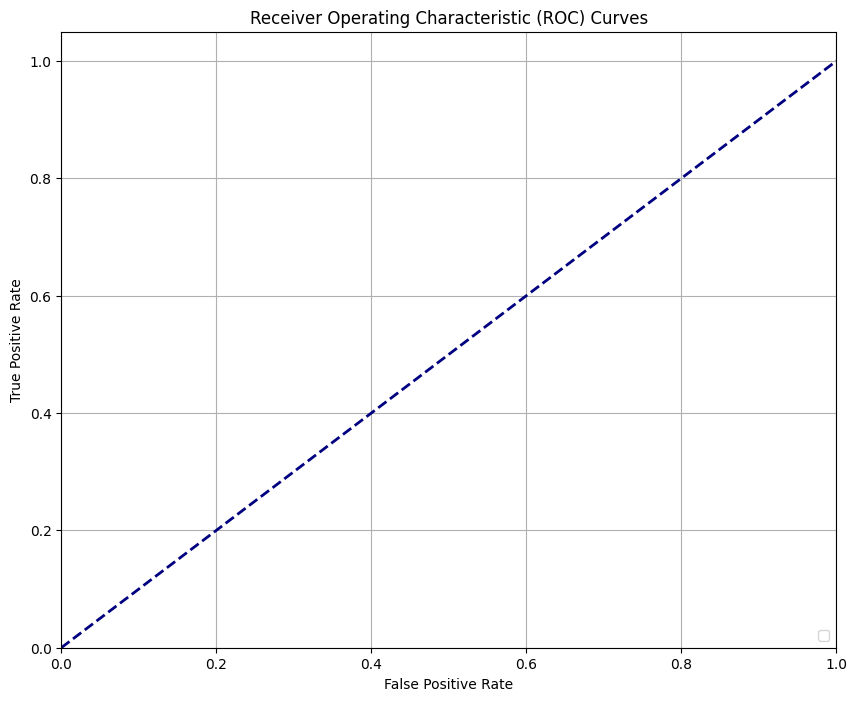

KeyError: 'Name'

In [ ]:
# --- file: notebooks/experiments.ipynb ---

# --- Cell: Final Results and Visualization ---

# ================================================
# 1. Quantitative Analysis: Summary Table
# ================================================
# Create a summary DataFrame from the 'experiments' dictionary
summary_df = pd.DataFrame([
    {
        'Architecture': name,
        'ROC-AUC': result['auc'],
        'Training Time (s)': round(result['time'], 1)
    } 
    for name, result in experiments.items()
])

print("\n--- Final Results Summary ---")
# Display the formatted DataFrame
display(summary_df.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True))


# ================================================
# 2. Visual Analysis: ROC Curves
# ================================================
print("\n--- Generating ROC Curves ---")
# This function will plot all models on a single graph for direct comparison
plot_roc_curves(experiments)


# ================================================
# 3. Visual Analysis: Embedding Space Quality
# ================================================
# We'll visualize the embeddings from our best text-based model: BERT

print("\n--- Generating Embedding Visualization for BERT Encoder ---")

# a. Create a random sample of 1000 books to plot
sample_book_ids = np.random.choice(text_features.index, 1000, replace=False)
sample_titles = text_features.loc[sample_book_ids]['title'].tolist()

# b. For coloring, let's try to find the real categories for these books
#    (If this fails, we can fall back to random labels)
try:
    sample_categories = books_df[books_df['book_id'].isin(sample_book_ids)]
    # A simple way to get the primary category
    sample_labels_text = sample_categories['categories'].str.extract(r'\'(\w+)\'').fillna('Unknown').iloc[:, 0]
    # Convert text labels to numbers for coloring
    labels_map, sample_labels_numeric = pd.factorize(sample_labels_text)
except Exception:
    print("Could not extract real categories, using random labels for coloring.")
    sample_labels_numeric = np.random.randint(0, 10, size=1000)

# c. Tokenize the sampled titles for the BERT encoder
tokenized_samples = tokenizer(sample_titles, max_length=MAX_TITLE_LENGTH, truncation=True, padding='max_length', return_tensors='np')
bert_input_data = {'input_ids': tokenized_samples['input_ids'], 'attention_mask': tokenized_samples['attention_mask']}

# d. Call the plotting function with the prepared data
plot_embeddings(
    encoder=experiments['BERT']['model'].encoder, # Get the encoder from our trained BERT model
    data=bert_input_data, 
    labels=sample_labels_numeric
)